In [1]:
%env KERAS_BACKEND=jax
%env XLA_PYTHON_CLIENT_PREALLOCATE=true
%env XLA_PYTHON_CLIENT_MEM_FRACTION=1.00
%env JAX_DEBUG_NANS=true

env: KERAS_BACKEND=jax
env: XLA_PYTHON_CLIENT_PREALLOCATE=true
env: XLA_PYTHON_CLIENT_MEM_FRACTION=1.00
env: JAX_DEBUG_NANS=true


In [2]:
from dataclasses import dataclass, field
from typing import List
from functools import partial

import jax
import keras_core as keras
import matplotlib as mpl
import numpy as np
from imax.project import (
    bilinear_sampler,
    cam2pixel,
    meshgrid,
    nearest_sampler,
    pixel2cam,
)
from jax import numpy as jnp
from matplotlib import pyplot as plt
from PIL import Image

mpl.rcParams["savefig.pad_inches"] = 0
plt.style.use("dark_background")

Using JAX backend.


In [3]:
def clamp(x, min=None, max=None):
    if min is not None:
        x = jnp.where(
            x < min,
            x + jax.lax.stop_gradient(min - x),
            x,
        )
    if max is not None:
        x = jnp.where(x > max, x / jax.lax.stop_gradient(x) * max, x)
    return x



#@partial(jax.jit, static_argnames=["image_size", "channels", "kernel_size"])
def generate_2D_gaussian_splatting(
    sigma_x,
    sigma_y,
    # sigma_z,
    rho,
    coords,
    colors,
    image_size,
    channels,
):
    batch_size = colors.shape[0]
    kernel_size = max(image_size)
    sigma_x = sigma_x.reshape((batch_size, 1, 1))
    sigma_y = sigma_y.reshape((batch_size, 1, 1))
    # sigma_z = sigma_z.reshape((batch_size, 1, 1))
    rho = rho.reshape((batch_size, 1, 1))

    covariance = jnp.stack(
        [
            jnp.stack([sigma_x**2, rho * sigma_x * sigma_y], axis=-1),
            jnp.stack([rho * sigma_x * sigma_y, sigma_y**2], axis=-1),
        ],
        axis=-2,
    )

    # Check for positive semi-definiteness
    determinant = (sigma_x**2) * (sigma_y**2) - (rho * sigma_x * sigma_y) ** 2
    # determinant = jax.lax.clamp(1e-6, determinant, jnp.inf)

    inv_covariance = jnp.linalg.inv(covariance)

    ax_batch = jnp.linspace(-1.0, 1.0, num=kernel_size)[None, ...]

    # Expanding dims for broadcasting
    ax_batch_expanded_x = jnp.tile(ax_batch[..., None], (1, 1, kernel_size))
    ax_batch_expanded_y = jnp.tile(ax_batch[:, None, ...], (1, kernel_size, 1))

    # Creating a batch-wise meshgrid using broadcasting
    xx, yy = ax_batch_expanded_x, ax_batch_expanded_y

    xy = jnp.stack([xx, yy], axis=-1)
    xy = xy + coords[:, None, None, :]

    z = jnp.einsum("b...i,b...ij,b...j->b...", xy, -0.5 * inv_covariance, xy)
    kernel = jnp.exp(z) / (
        2
        * jnp.pi
        * jnp.sqrt(jnp.linalg.det(covariance)).reshape((batch_size, 1, 1))
        + 1e-6
    )

    kernel_max_1 = kernel.max(axis=-1, keepdims=True)
    kernel_max_2 = kernel_max_1.max(
        axis=-2, keepdims=True
    )  # Find max along the second-to-last dimension
    kernel_normalized = kernel / kernel_max_2

    kernel_reshaped = jnp.reshape(
        jnp.tile(kernel_normalized, (1, channels, 1)),
        (batch_size * channels, kernel_size, kernel_size),
    )
    kernel_rgb = kernel_reshaped.reshape(batch_size, channels, kernel_size, kernel_size)

    # Calculating the padding needed to match the image size
    pad_h = int(image_size[0]) - kernel_size
    pad_w = int(image_size[1]) - kernel_size

    if pad_h < 0 or pad_w < 0:
        raise ValueError("Kernel size should be smaller or equal to the image size.")

    # Adding padding to make kernel size equal to the image size
    padding = (
        (0, 0),
        (0, 0),
        (pad_w // 2, pad_w // 2 + pad_w % 2),  # padding top and bottom
        (pad_h // 2, pad_h // 2 + pad_h % 2),  # padding left and right
    )

    kernel_rgb_padded = jnp.pad(kernel_rgb, padding, "constant")
    kernel_rgb_padded = jnp.transpose(kernel_rgb_padded, (0, 2, 3, 1))

    # Extracting shape information
    b, h, w, c = kernel_rgb_padded.shape

    # Create a batch of 2D affine matrices
    intrinsics_0 = jnp.eye(2)
    intrinsics_0 = jnp.concatenate(
        [intrinsics_0, jnp.array([[(w - 1) / 2], [(h - 1) / 2]]), jnp.zeros((2, 1))],
        axis=1,
    )
    intrinsics_1 = jnp.array([[0, 0, 1, 0], [0, 0, 0, 1]], dtype="float32")
    intrinsics = jnp.concatenate([intrinsics_0, intrinsics_1], axis=0)
    # intrinsics = jnp.tile(intrinsics[None, ...], (b,1,1))

    depth = jnp.ones(shape=(h, w))

    # Creating grid and performing grid sampling
    pixel_coords = meshgrid(h, w)
    # Convert pixel coordinates to the camera frame
    cam_coords = pixel2cam(depth, pixel_coords, intrinsics[:3, :3])

    src_pixel_coords = cam2pixel(cam_coords, intrinsics)
    kernel_rgb_padded_translated = jax.vmap(
        lambda rgb: nearest_sampler(  # bilinear_sampler
            rgb, src_pixel_coords, mask_value=jnp.array([0.0, 0.0, 0.0])
        )
    )(kernel_rgb_padded)

    rgb_values_reshaped = colors[..., None, None, :]

    final_image_layers = rgb_values_reshaped * kernel_rgb_padded_translated
    final_image = final_image_layers.sum(axis=0)
    # final_image = jax.lax.clamp(0.0, final_image, max=1.0)
    return final_image

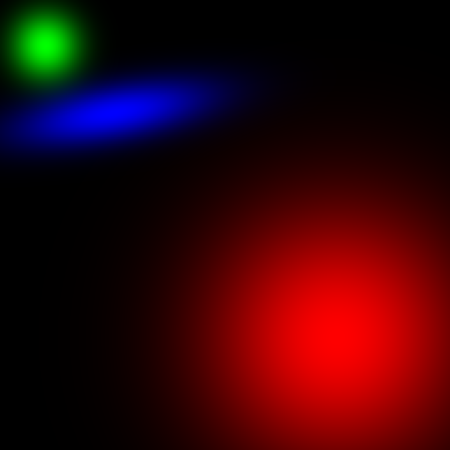

In [4]:
rho = jnp.array([0.0, 0.0, -0.5])
sigma_x = jnp.array([0.4, 0.1, 0.1])
sigma_y = jnp.array([0.4, 0.1, 0.3])
vectors = jnp.array([(-0.5, -0.5), (0.8, 0.8), (0.5, 0.5)])
# colors = jnp.array([(1.0, 0.0, 0.0, 1.0), (0.0, 1.0, 0.0, 1.0), (0.0, 0.0, 1.0, 1.0)])
colors = jnp.array([(1.0, 0.0, 0.0), (0.0, 1.0, 0.0), (0.0, 0.0, 1.0)])
img_size = (256, 256)
channels = 3

final_image = generate_2D_gaussian_splatting(
    sigma_x, sigma_y, rho, vectors, colors, img_size, channels
)

plt.imshow(final_image)
plt.axis("off")
plt.tight_layout()
plt.show()

In [5]:
# grad_fn = jax.grad(lambda x: jnp.mean(generate_2D_gaussian_splatting(*x)))
# grad = grad_fn((sigma_x, sigma_y, rho, vectors, colors, img_size))
# print(grad)

In [6]:
def create_window(window_size, channel):
    def gaussian(window_size, sigma):
        gauss = jnp.exp(
            jnp.array(
                [
                    -((x - window_size // 2) ** 2) / float(2 * sigma**2)
                    for x in range(window_size)
                ]
            )
        )
        return gauss / gauss.sum()

    _1D_window = gaussian(window_size, 1.5)[..., None]
    _2D_window = jnp.matmul(_1D_window, _1D_window.T)[None, None, ...]
    window = jnp.broadcast_to(_2D_window, (channel, 1, window_size, window_size))
    return window


def conv2d(inputs, kernel, padding, groups):
    out = jax.lax.conv_general_dilated(
        inputs,  # lhs = NCHW image tensor
        kernel,  # rhs = OIHW conv kernel tensor
        (1, 1),  # window strides
        "VALID",  # padding mode
        feature_group_count=groups,
    )
    out = jnp.pad(
        out, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode="edge"
    )
    return out


# print(conv2d(jnp.ones((1, 3,10,10)), kernel=jnp.ones((3, 1, 3, 3)), padding=1, groups=3).shape)


def ssim(img1, img2, window_size=11):
    channel = img1.shape[-1]

    img1 = jnp.transpose(img1, (0, 3, 1, 2))
    img2 = jnp.transpose(img2, (0, 3, 1, 2))

    # Parameters for SSIM
    C1 = 0.01**2
    C2 = 0.03**2

    window = create_window(window_size, channel).astype(img1.dtype)

    mu1 = conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = conv2d(img2, window, padding=window_size // 2, groups=channel)
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = (
        conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    )
    sigma2_sq = (
        conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    )
    sigma12 = (
        conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2
    )

    SSIM_numerator = (2 * mu1_mu2 + C1) * (2 * sigma12 + C2)
    SSIM_denominator = (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2) + 1e-6
    SSIM = SSIM_numerator / SSIM_denominator

    return (1 - SSIM) / 2


# def ssim(
#     a,
#     b,
#     max_val: float = 1.0,
#     filter_size: int = 11,
#     filter_sigma: float = 1.5,
#     k1: float = 0.01,
#     k2: float = 0.03,
#     precision=jax.lax.Precision.HIGHEST,
#     # filter_fn: Optional[Callable[[chex.Array], chex.Array]] = None,
# ):
#     """Computes the structural similarity index (SSIM) between image pairs.

#     This function is based on the standard SSIM implementation from:
#     Z. Wang, A. C. Bovik, H. R. Sheikh and E. P. Simoncelli,
#     "Image quality assessment: from error visibility to structural similarity",
#     in IEEE Transactions on Image Processing, vol. 13, no. 4, pp. 600-612, 2004.

#     This function was modeled after tf.image.ssim, and should produce comparable
#     output.

#     Note: the true SSIM is only defined on grayscale. This function does not
#     perform any colorspace transform. If the input is in a color space, then it
#     will compute the average SSIM.

#     Args:
#       a: First image (or set of images).
#       b: Second image (or set of images).
#       max_val: The maximum magnitude that `a` or `b` can have.
#       filter_size: Window size (>= 1). Image dims must be at least this small.
#       filter_sigma: The bandwidth of the Gaussian used for filtering (> 0.).
#       k1: One of the SSIM dampening parameters (> 0.).
#       k2: One of the SSIM dampening parameters (> 0.).
#       return_map: If True, will cause the per-pixel SSIM "map" to be returned.
#       precision: The numerical precision to use when performing convolution.
#       filter_fn: An optional argument for overriding the filter function used by
#         SSIM, which would otherwise be a 2D Gaussian blur specified by filter_size
#         and filter_sigma.

#     Returns:
#       Each image's mean SSIM, or a tensor of individual values if `return_map`.
#     """
#     # chex.assert_rank([a, b], {3, 4})
#     # chex.assert_type([a, b], float)
#     # chex.assert_equal_shape([a, b])

#     # Construct a 1D Gaussian blur filter.
#     hw = filter_size // 2
#     shift = (2 * hw - filter_size + 1) / 2
#     f_i = ((jnp.arange(filter_size) - hw + shift) / filter_sigma) ** 2
#     filt = jnp.exp(-0.5 * f_i)
#     filt /= jnp.sum(filt)

#     # Construct a 1D convolution.
#     def filter_fn_1(z):
#         return jnp.convolve(z, filt, mode="valid", precision=precision)

#     filter_fn_vmap = jax.vmap(filter_fn_1)

#     # Apply the vectorized filter along the y axis.
#     def filter_fn_y(z):
#         z_flat = jnp.moveaxis(z, -3, -1).reshape((-1, z.shape[-3]))
#         z_filtered_shape = ((z.shape[-4],) if z.ndim == 4 else ()) + (
#             z.shape[-2],
#             z.shape[-1],
#             -1,
#         )
#         z_filtered = jnp.moveaxis(
#             filter_fn_vmap(z_flat).reshape(z_filtered_shape), -1, -3
#         )
#         return z_filtered

#     # Apply the vectorized filter along the x axis.
#     def filter_fn_x(z):
#         z_flat = jnp.moveaxis(z, -2, -1).reshape((-1, z.shape[-2]))
#         z_filtered_shape = ((z.shape[-4],) if z.ndim == 4 else ()) + (
#             z.shape[-3],
#             z.shape[-1],
#             -1,
#         )
#         z_filtered = jnp.moveaxis(
#             filter_fn_vmap(z_flat).reshape(z_filtered_shape), -1, -2
#         )
#         return z_filtered

#     # Apply the blur in both x and y.
#     filter_fn = lambda z: filter_fn_y(filter_fn_x(z))

#     mu0 = filter_fn(a)
#     mu1 = filter_fn(b)
#     mu00 = mu0 * mu0
#     mu11 = mu1 * mu1
#     mu01 = mu0 * mu1
#     sigma00 = filter_fn(a**2) - mu00
#     sigma11 = filter_fn(b**2) - mu11
#     sigma01 = filter_fn(a * b) - mu01

#     # Clip the variances and covariances to valid values.
#     # Variance must be non-negative:
#     epsilon = jnp.finfo(jnp.float32).eps ** 2
#     sigma00 = jnp.maximum(epsilon, sigma00)
#     sigma11 = jnp.maximum(epsilon, sigma11)
#     sigma01 = jnp.sign(sigma01) * jnp.minimum(
#         jnp.sqrt(sigma00 * sigma11 + 1e-12), jnp.abs(sigma01)
#     )

#     c1 = (k1 * max_val) ** 2
#     c2 = (k2 * max_val) ** 2
#     numer = (2 * mu01 + c1) * (2 * sigma01 + c2)
#     denom = (mu00 + mu11 + c1) * (sigma00 + sigma11 + c2)
#     ssim_map = numer / denom
#     return ssim_map


def d_ssim_loss(img1, img2):
    return ssim(img1, img2).mean()


def l1_loss(pred, target):
    return jnp.abs(target - pred).mean()


# Combined Loss
def combined_loss(pred, target, lambda_param=0.5):
    return (1 - lambda_param) * l1_loss(pred, target) + lambda_param * d_ssim_loss(
        pred, target
    )


print(combined_loss(jnp.ones((1, 100, 100, 3)), jnp.ones((1, 100, 100, 3)) * 0.5))

0.30016044


In [7]:
!wget -nc 'https://raw.githubusercontent.com/OutofAi/2D-Gaussian-Splatting/main/Image-01.png'

!wget -nc 'https://raw.githubusercontent.com/OutofAi/2D-Gaussian-Splatting/main/config.yml'

File ‘Image-01.png’ already there; not retrieving.

File ‘config.yml’ already there; not retrieving.



In [8]:
@dataclass
class Config:
    image_size: tuple[int] = field(default_factory=lambda: (64, 64))
    channels: int = 3
    samples: int = 4000
    num_epochs: int = 2000
    densification_interval: int = 200
    learning_rate: float = 0.01  # 0.01
    image_file_name: str = "Image-01.png"
    display_interval: int = 100
    gradient_threshold: float = 0.02
    gaussian_threshold: float = 0.75

In [9]:
config = Config()

num_samples = config.samples

original_image = Image.open(config.image_file_name)
original_image = original_image.resize(
    (int(config.image_size[0]), int(config.image_size[0]))
)
original_image = original_image.convert("RGB")
original_array = jnp.array(original_image)
original_array = original_array / 255.0
width, height, _ = original_array.shape

image_array = original_array
target = jnp.array(image_array, dtype="float32")

In [10]:
def give_required_data(input_coords, image=target):
    # normalising pixel coordinates [-1,1]
    coords = jnp.array(
        input_coords / jnp.array([image.shape[0], image.shape[1]]), dtype="float32"
    )
    center_coords_normalized = jnp.array([0.5, 0.5]).astype("float32")
    coords = (center_coords_normalized - coords) * 2.0

    # Fetching the colour of the pixels in each coordinates
    colour_values = jnp.array(
        [image[coord[1], coord[0]] for coord in input_coords]
    ).astype("float32")

    return colour_values, coords

In [11]:
# class MinMaxActivation(keras.constraints.Constraint):
#     def __init__(self, min, max, **kwargs):
#         super().__init__(**kwargs)
#         self.min = min
#         self.max = max

#     def __call__(self, w):
#         return keras.ops.clip(jnp.array(w), self.min, self.max)

class Splatter(keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        self.config = config
        self.channels = int(config.image_size[-1])
        self.num_samples = self.config.samples
        
        input_coords = np.random.randint(0, [target.shape[0], target.shape[1]], size=(self.num_samples, 2))
        
        self.color_vals, self.pixel_coords = give_required_data(input_coords)
        self.color_vals = self.color_vals / self.config.samples

    def build(self):
        self.rho = self.add_weight(
            shape=(self.num_samples, 1),
            initializer="ones",  #keras.initializers.RandomUniform(minval=-1.0, maxval=1.0),
            # constraint=MinMaxActivation(-2., 2.),
            trainable=True,
        )
        self.sigma_x = self.add_weight(
            shape=(self.num_samples, 1),
            initializer="ones",  #keras.initializers.RandomUniform(minval=0.01, maxval=1.0),
            # constraint=MinMaxActivation(-1., 2.),
            trainable=True,
        )
        self.sigma_y = self.add_weight(
            shape=(self.num_samples, 1),
            initializer="ones",  #keras.initializers.RandomUniform(minval=0.01, maxval=1.0),
            # constraint=MinMaxActivation(-1., 2.),
            trainable=True,
        )
        self.coords = self.add_weight(
            shape=(self.num_samples, 2),
            initializer=keras.initializers.RandomUniform(minval=-1.0, maxval=1.0),  # "random_normal",  # lambda shape, dtype: self.pixel_coords,
            # constraint=MinMaxActivation(-2., 2.),
            trainable=True,
        )
        self.alpha = self.add_weight(
            shape=(self.num_samples, 1),
            initializer="ones",  # keras.initializers.RandomUniform(minval=1.0, maxval=1.0),
            # constraint=MinMaxActivation(-1., 2.),
            trainable=True,
        )
        self.colors = self.add_weight(
            shape=(self.num_samples, 3),
            initializer="zeros",  # lambda shape, dtype: jnp.zeros_like(self.color_vals),
            # constraint=MinMaxActivation(-2., 2.),
            trainable=True,
        )

    def call(self, inputs, training=False):
        
        alpha = keras.ops.sigmoid(jnp.array(self.alpha))

        mask = jnp.array(jnp.nonzero(alpha[:, 0] > 0.01, size=1000))[0]
        
        # mask = mask[:, 0]
        alpha = alpha[mask] * jnp.greater(mask, 0).astype(alpha.dtype)[:, None]
        
        rho = self.rho[mask]
        sigma_x = self.sigma_x[mask]
        sigma_y = self.sigma_y[mask]
        coords = self.coords[mask]
        colors = self.colors[mask]
        

        # if training:
        #     noise = keras.random.normal(alpha.shape, mean=0.0, stddev=0.1)
        #     alpha = keras.random.dropout(alpha, rate=0.2) * noise
        
        return (
            keras.ops.tanh(jnp.array(rho)),
            -keras.ops.tanh(jnp.array(sigma_x)),
            -keras.ops.tanh(jnp.array(sigma_y)),
            keras.ops.tanh(jnp.array(coords)),
            keras.ops.tanh(jnp.array(colors)) * alpha,
        )


class SplatterModel(keras.Model):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        self.config = config
        self.splatter = Splatter(config)
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_loss_and_updates(
        self,
        trainable_variables,
        non_trainable_variables,
        x,
        target,
        # pose,
        training=False,
    ):
        pred, non_trainable_variables = self.stateless_call(
            trainable_variables,
            non_trainable_variables,
            x,
            training=training,
        )
        rho, sigma_x, sigma_y, coords, colors = pred
        splatted = generate_2D_gaussian_splatting(
            sigma_x, sigma_y, rho, coords, colors, self.config.image_size, self.config.channels
        )
        loss = combined_loss(splatted[None, ..., :], target, lambda_param=0.5)
        return loss, (splatted, non_trainable_variables)

    def call(self, data, training=False):
        return self.splatter(data)

    def train_step(self, state, data):
        (
            trainable_variables,
            non_trainable_variables,
            optimizer_variables,
            metrics_variables,
        ) = state
        (x, target) = data

        # Get the gradient function.
        grad_fn = jax.value_and_grad(self.compute_loss_and_updates, has_aux=True)

        # Compute the gradients.
        (loss, (splatted, non_trainable_variables)), grads = grad_fn(
            trainable_variables,
            non_trainable_variables,
            x,
            target,
            # pose,
            training=True,
        )

        # Update trainable variables and optimizer variables.
        (
            trainable_variables,
            optimizer_variables,
        ) = self.optimizer.stateless_apply(
            optimizer_variables, grads, trainable_variables
        )

        # Update metrics.
        loss_tracker_vars = metrics_variables[: len(self.loss_tracker.variables)]
        mae_metric_vars = metrics_variables[len(self.loss_tracker.variables) :]

        loss_tracker_vars = self.loss_tracker.stateless_update_state(
            loss_tracker_vars, loss
        )

        logs = {}
        logs[self.loss_tracker.name] = self.loss_tracker.stateless_result(
            loss_tracker_vars
        )

        new_metrics_vars = loss_tracker_vars

        # Return metric logs and updated state variables.
        state = (
            trainable_variables,
            non_trainable_variables,
            optimizer_variables,
            new_metrics_vars,
        )
        return logs, state

In [12]:
class ImageCallback(keras.callbacks.Callback):
    def __init__(self, target):
        super().__init__()
        self.target = target

    def on_train_begin(self, logs=None):
        plt.imshow(self.target)
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.clf()
        plt.close()

    def on_epoch_end(self, epoch, logs={}):
        rho, sigma_x, sigma_y, coords, colors = self.model.predict(
            jnp.array([1.0])
        )
        image = generate_2D_gaussian_splatting(
            sigma_x,
            sigma_y,
            # sigma_z,
            rho,
            coords,
            colors,
            self.model.config.image_size,
            self.model.config.channels,
        )
        plt.imshow(image[:, :, :3])
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.clf()  # Clear the current figure
        plt.close()  # Close the current figure

2023-11-15 16:10:44.070702: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 16:10:44.070727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 16:10:44.070758: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


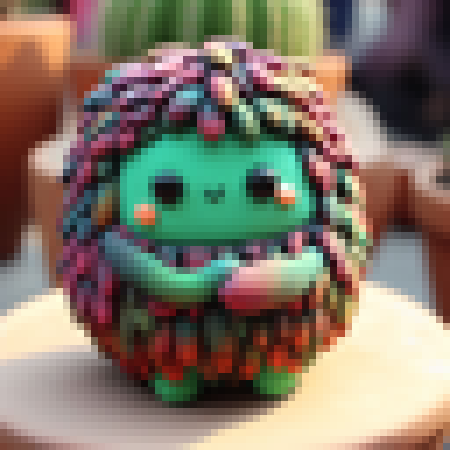

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/stepp - loss: 0.51


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


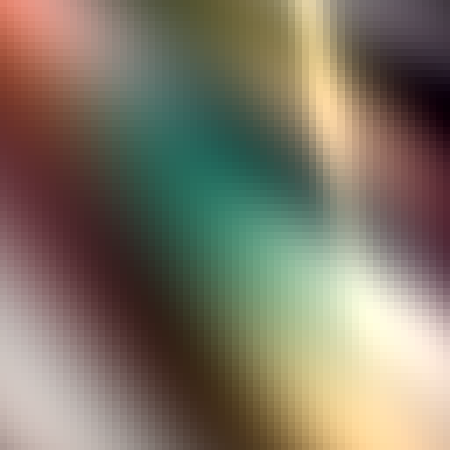

100/100 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - loss: 0.5161
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/stepep - loss: 0.243


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


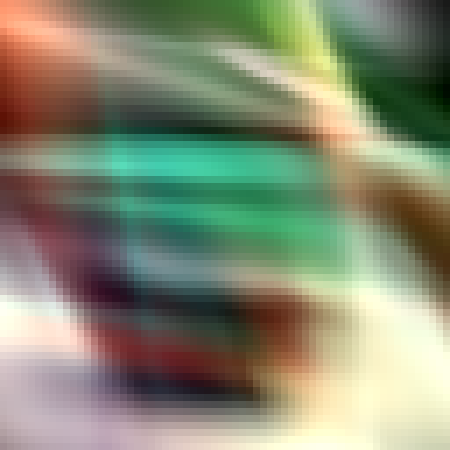

100/100 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - loss: 0.2432
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/stepep - loss: 0.154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


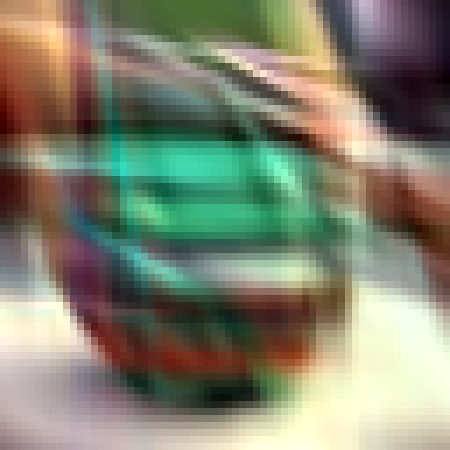

100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 0.1543
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - loss: 0.107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


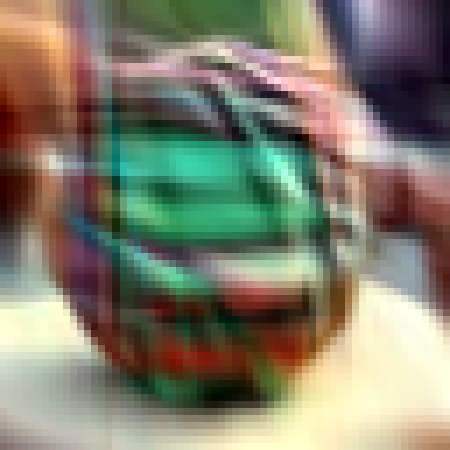

100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 0.1076
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - loss: 0.086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


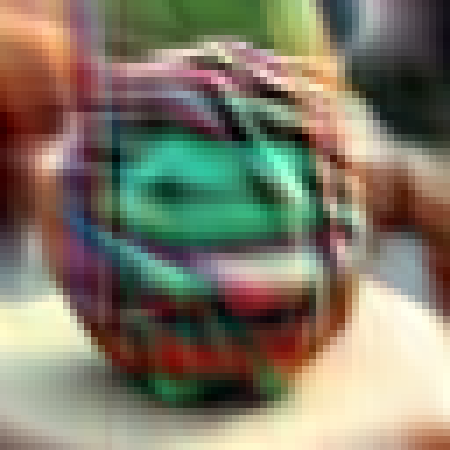

100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - loss: 0.0869
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - loss: 0.069


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


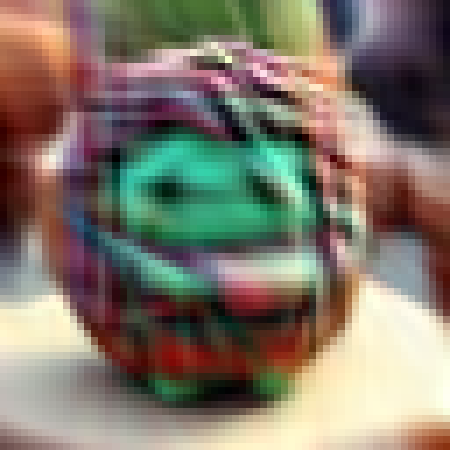

100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 0.0695
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - loss: 0.060


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


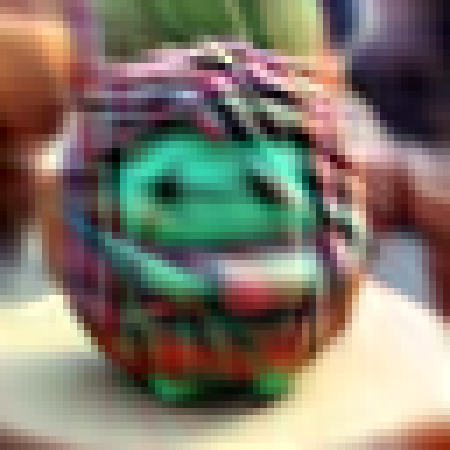

100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 0.0608
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - loss: 0.055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


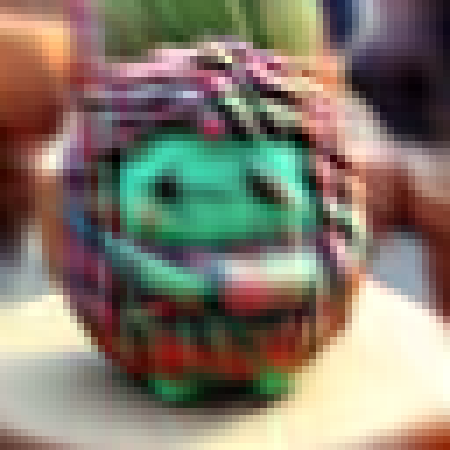

100/100 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - loss: 0.0551
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - loss: 0.052


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


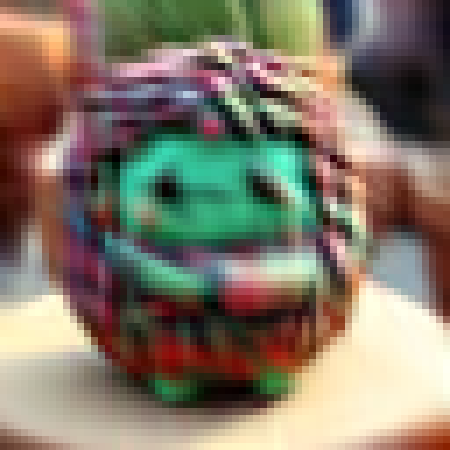

100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 0.0521
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - loss: 0.046


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


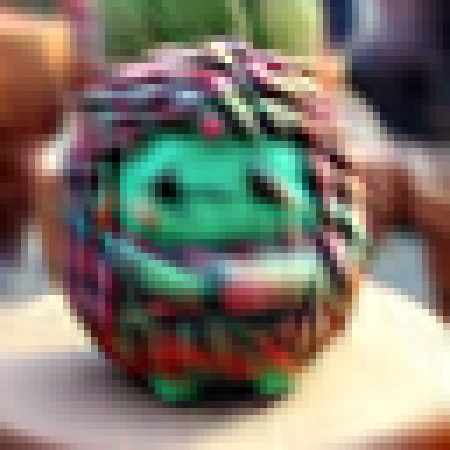

100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 0.0465
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - loss: 0.043


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


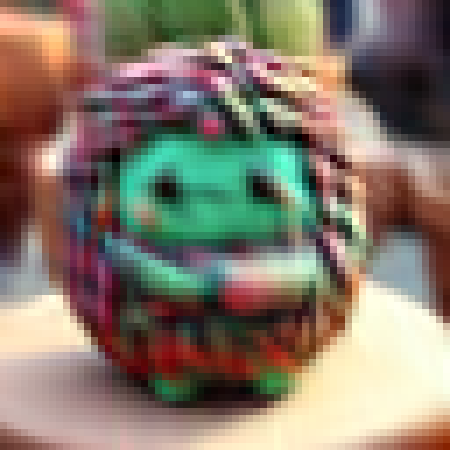

100/100 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - loss: 0.0439
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/stepep - loss: 0.041


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


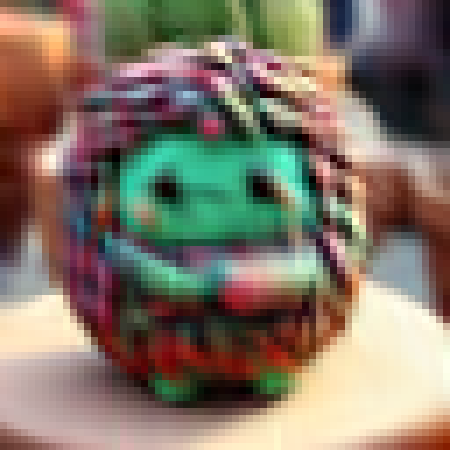

100/100 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - loss: 0.0418
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/stepep - loss: 0.039


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


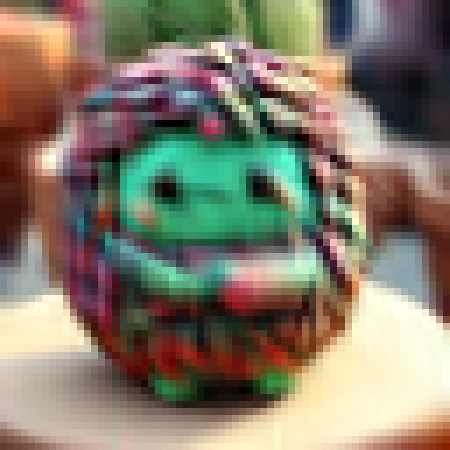

100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 0.0399
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - loss: 0.038


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


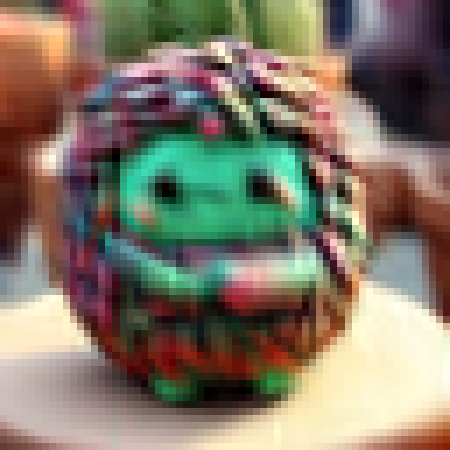

100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 0.0382
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - loss: 0.036


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


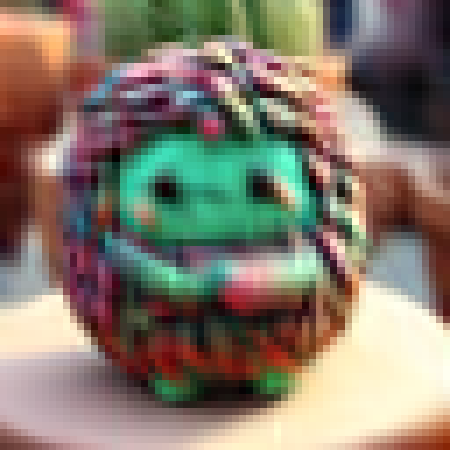

100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 0.0364
Epoch 16/100
 69/100 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.0346Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in jit(mul)

In [13]:
splatter = SplatterModel(config=config)

optimizer = keras.optimizers.Adam(config.learning_rate)

splatter.compile(optimizer, run_eagerly=True)

gen = ((jnp.ones((1,)), target[None, ...]) for r in iter(int, 1))

splatter.fit(
    gen,
    epochs=100,
    steps_per_epoch=100,
    shuffle=False,
    callbacks=[ImageCallback(target)],
)

In [ ]:
rho, sigma_x, sigma_y, coords, colors = splatter(
    jnp.array([1.0]), training=False
)

print(rho.shape)

final_image = generate_2D_gaussian_splatting(
    sigma_x,
    sigma_y,
    # sigma_z,
    rho,
    coords,
    colors,
    img_size,
    3
)

plt.imshow(target)
plt.axis("off")
plt.tight_layout()
plt.show()

plt.imshow(final_image[:, :, :3])
plt.axis("off")
plt.tight_layout()
plt.show()